<a href="https://colab.research.google.com/github/MutianWang/novel-cell/blob/main/human/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novel Cells Generation

In [1]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/Colab Notebooks/Brain Cell/data/'

## Preprocessing

In [ ]:
meta = pd.read_csv(path+'meta.csv', header=0)
cols_glut = meta[meta['class']=='Glutamatergic']['sample_name']
cols_non = meta[meta['class']=='Non-neuronal']['sample_name']
cols_gaba = meta[meta['class']=='GABAergic']['sample_name']

In [ ]:
def normalize(df):
    # counts per million
    df = df.div(df.sum(axis=1), axis=0) * 10**6
    df = df.fillna(0)
    return df

In [ ]:
def read_expression(file1, file2, usecols):
    # point-wise addition of exon and intron tables
    reader1 = pd.read_csv(file1, header=0, usecols=usecols, chunksize=1000)
    reader2 = pd.read_csv(file2, header=0, usecols=usecols, chunksize=1000)

    df = reader1.get_chunk() + reader2.get_chunk()
    for i in range(1, 51):
        df = pd.concat([df, reader1.get_chunk() + reader2.get_chunk()])
        if i%10==0:
            print('{}/50'.format(i))

    return df.transpose()

In [ ]:
exp_glut = read_expression(path+'exon.csv', path+'intron.csv', cols_glut) # 10525 * 50281
exp_glut = exp_glut.sample(5000-914) # 4086 * 50281
exp_glut = normalize(exp_glut)
np.save(path+'exp_glut', exp_glut)
del exp_glut

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_non = read_expression(path+'exon.csv', path+'intron.csv', cols_non) # 914 * 50281
exp_non = normalize(exp_non)
np.save(path+'exp_non', exp_non)
del exp_non

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_gaba = read_expression(path+'exon.csv', path+'intron.csv', cols_gaba) # 4164 * 50281
exp_gaba = normalize(exp_gaba)
np.save(path+'exp_gaba', exp_gaba)
del exp_gaba

10/50
20/50
30/50
40/50
50/50


In [ ]:
# first 4086 are Glutamatergic, last 914 are Non-neuronal
exp_train = np.concatenate([np.load(path+'exp_glut.npy'), 
                            np.load(path+'exp_non.npy')], axis=0)
np.save(path+'exp_train', exp_train)

## Dimension Reduction

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
pipe = Pipeline([('scaler1', StandardScaler()), ('pca', PCA(n_components=4000)), ('scaler2', MinMaxScaler())])

In [ ]:
exp_train = np.load(path+'exp_train.npy')
exp_train = pipe.fit_transform(exp_train)
np.save(path+'exp_train_pca', exp_train)
del exp_train

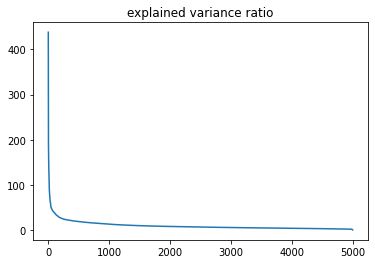

In [ ]:
# set n_components=5000 to plot this graph
#plt.plot(pipe['pca'].explained_variance_);
#plt.title('explained variance ratio');

In [ ]:
exp_test = np.load(path+'exp_gaba.npy')
exp_test = pipe.transform(exp_test)
np.save(path+'exp_test_pca', exp_test)
del exp_test

## GAN

In [5]:
exp_train = np.load(path+'exp_train_pca.npy')

In [6]:
dimension = exp_train.shape[1]

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=True, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1024, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(2048, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # sigmoid function will make the range [0,1]
    model.add(layers.Dense(dimension, use_bias=True, activation='linear'))

    return model

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(2048, use_bias=True, input_shape=(dimension,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1024, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1))

    return model

In [10]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              8194048   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)              

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [16]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 128])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [17]:
def train(dataset, epochs):
    loss_hist = []
    gen_loss_hist = []
    disc_loss_hist = []
    for epoch in range(epochs):
        start = time.time()

        gen_loss = 0
        disc_loss = 0
        for data in dataset:
            loss1, loss2 = train_step(data)
            gen_loss += loss1
            disc_loss += loss2

        print ('Time for epoch {} is {} sec. Loss is {}'.format(epoch + 1, time.time()-start, gen_loss+disc_loss))
        
        loss_hist.append(gen_loss+disc_loss)
        gen_loss_hist.append(gen_loss)
        disc_loss_hist.append(disc_loss)
        if epoch > 2:
            if abs(loss_hist[-1] - loss_hist[-2]) < 0.5 and abs(loss_hist[-2] - loss_hist[-3]) < 0.5:
                return loss_hist

    return loss_hist, gen_loss_hist, disc_loss_hist

In [18]:
BATCH_SIZE = 500
dataset = tf.data.Dataset.from_tensor_slices(exp_train).shuffle(1000).batch(BATCH_SIZE)

In [19]:
hist = train(dataset, 1000)

Time for epoch 1 is 2.569213628768921 sec. Loss is 169.87228393554688
Time for epoch 2 is 0.8577663898468018 sec. Loss is 138.68173217773438
Time for epoch 3 is 0.8052992820739746 sec. Loss is 121.69956970214844
Time for epoch 4 is 0.7998824119567871 sec. Loss is 826.783203125
Time for epoch 5 is 0.8123395442962646 sec. Loss is 647.76513671875
Time for epoch 6 is 0.7883172035217285 sec. Loss is 1185.0078125
Time for epoch 7 is 0.8024871349334717 sec. Loss is 1656.0362548828125
Time for epoch 8 is 0.7925493717193604 sec. Loss is 647.976806640625
Time for epoch 9 is 0.7955124378204346 sec. Loss is 1854.756103515625
Time for epoch 10 is 0.7790100574493408 sec. Loss is 1463.91796875
Time for epoch 11 is 0.7787289619445801 sec. Loss is 909.6656494140625
Time for epoch 12 is 0.778714656829834 sec. Loss is 1767.39306640625
Time for epoch 13 is 0.7877330780029297 sec. Loss is 1086.997314453125
Time for epoch 14 is 0.784125804901123 sec. Loss is 1721.8277587890625
Time for epoch 15 is 0.7786660

In [20]:
exp_gen = generator(tf.random.normal([1000,128]))

## Evaluation

### Nearest Neighbor

In [26]:
from scipy.spatial import distance

In [27]:
def distance_classify(metric, centers, gens):
    if metric == 'l1':
        dist = lambda x, y: np.sum(np.abs(x-y))
    elif metric == 'l2':
        dist = lambda x, y: np.sum(np.square(x-y))
    elif metric == 'cosine' or metric == 'cos':
        dist = lambda x, y: distance.cosine(x, y)
    else:
        return

    res = [0, 0, 0]
    res1 = []
    res2 = []
    res3 = []
    for gen in gens:
        res1.append(dist(gen, centers[0]))
        res2.append(dist(gen, centers[1]))
        res3.append(dist(gen, centers[2]))

        i = np.argmin([res1[-1], res2[-1], res3[-1]])
        res[i] += 1

    return res


#### mean center

In [28]:
mean_glut = np.mean(np.load(path+'exp_train_pca.npy')[:4086], axis=0)
mean_non = np.mean(np.load(path+'exp_train_pca.npy')[4086:], axis=0)
mean_gaba = np.mean(np.load(path+'exp_test_pca.npy'), axis=0)

mean_centers = [mean_glut, mean_non, mean_gaba]

In [29]:
# L1 distance
res = distance_classify('l1', mean_centers, exp_gen)
print(res)

[478, 144, 378]


In [30]:
# L2 distance
res = distance_classify('l2', mean_centers, exp_gen)
print(res)

[482, 518, 0]


In [31]:
# cosine distance
res = distance_classify('cosine', mean_centers, exp_gen)
print(res)

[496, 504, 0]


#### median center

In [32]:
median_glut = np.median(np.load(path+'exp_train_pca.npy')[:4086], axis=0)
median_non = np.median(np.load(path+'exp_train_pca.npy')[4086:], axis=0)
median_gaba = np.median(np.load(path+'exp_test_pca.npy'), axis=0)

median_centers = [median_glut, median_non, median_gaba]

In [33]:
# L1 distance
res = distance_classify('l1', median_centers, exp_gen)
print(res)

[479, 314, 207]


In [34]:
# L2 distance
res = distance_classify('l2', median_centers, exp_gen)
print(res)

[487, 513, 0]


In [35]:
# cosine distance
res = distance_classify('cosine', median_centers, exp_gen)
print(res)

[495, 505, 0]


### PCA + Visualization

#### 2D

In [21]:
exp_pca = np.concatenate([np.load(path+'exp_train_pca.npy'),
                          np.load(path+'exp_test_pca.npy')], axis=0)

In [22]:
pipe2 = Pipeline([('scaler1', StandardScaler()), ('pca', PCA(n_components=2))])

In [23]:
exp_pca = pipe2.fit_transform(exp_pca)

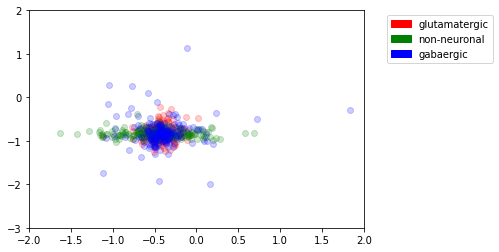

In [27]:
# red: glutamatergic
x, y = list(zip(*exp_pca[3000:3200]))
plt.scatter(x, y, c='r', alpha=0.2)
# green: non-neuronal
x, y = list(zip(*exp_pca[4700:4900]))
plt.scatter(x, y, c='g', alpha=0.2)
# blue: gabaergic
# some blue points are far away because 1st pca didn't see gaba data
x, y = list(zip(*exp_pca[7000:7200]))
plt.scatter(x, y, c='b', alpha=0.2)

plt.xlim(-2, 2);
plt.ylim(-3, 2);
patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
plt.legend(handles=[patch1, patch2, patch3], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()

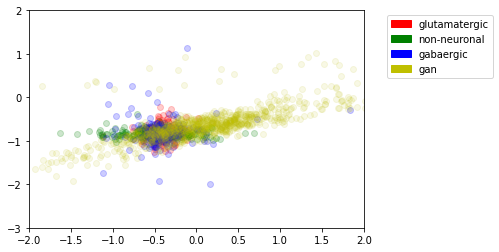

In [26]:
# red: glutamatergic
x, y = list(zip(*exp_pca[3000:3200]))
plt.scatter(x, y, c='r', alpha=0.2);
# green: non-neuronal
x, y = list(zip(*exp_pca[4700:4900]))
plt.scatter(x, y, c='g', alpha=0.2);
# blue: gabaergic
x, y = list(zip(*exp_pca[7000:7200]))
plt.scatter(x, y, c='b', alpha=0.2);
# yellow: gan
x, y = list(zip(*pipe2.transform(exp_gen)))
plt.scatter(x, y, c='y', alpha=0.1);

plt.xlim(-2, 2);
plt.ylim(-3, 2);
patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
patch4 = mpatches.Patch(color='y', label='gan');
plt.legend(handles=[patch1, patch2, patch3, patch4], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()

#### 3D

In [ ]:
exp_pca = np.concatenate([np.load(path+'exp_train_pca.npy'),
                          np.load(path+'exp_test_pca.npy')], axis=0)

In [ ]:
pipe3 = Pipeline([('scaler1', StandardScaler()), ('pca', PCA(n_components=3))])

In [ ]:
exp_pca = pipe3.fit_transform(exp_pca)

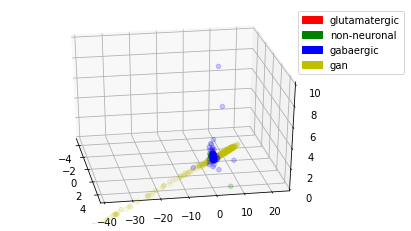

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# red: glutamatergic
x, y, z = list(zip(*exp_pca[3000:3200]))
ax.scatter3D(x, y, z, c='r', alpha=0.2);
# green: non-neuronal
x, y, z = list(zip(*exp_pca[4700:4900]))
ax.scatter3D(x, y, z, c='g', alpha=0.2);
# blue: gabaergic
x, y, z = list(zip(*exp_pca[7000:7200]))
ax.scatter3D(x, y, z, c='b', alpha=0.2);
# yellow: gan
x, y, z = list(zip(*pipe2.transform(exp_gen)))
ax.scatter3D(x, y, z, c='y', alpha=0.1);

ax.set_xlim(-5, 5);
ax.set_ylim(-40, 25);
ax.set_zlim(0,10);
ax.view_init(30, -10);

patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
patch4 = mpatches.Patch(color='y', label='gan');
plt.legend(handles=[patch1, patch2, patch3, patch4], 
           loc='upper right', bbox_to_anchor=(1.2, 1));
plt.show();